In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess
from deepcell.applications import MultiplexSegmentation

In [2]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20201018_multiplex_final_seed_1_nuclear_"
#This notebook assumes that the train dataset is already in 512x512 format, while val is in 256x256
train_dict = np.load(r"C:\Users\miles\GitHub\MESMER_training\training_datasets\tissuenet_v1.1\tissuenet_v1.1_train.npz")
val_dict = np.load(r"C:\Users\miles\GitHub\MESMER_training\training_datasets\tissuenet_v1.1\tissuenet_v1.1_val.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

This cell below is used for visulisation 

In [3]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [4]:
rgb_data = make_color_overlay(X_train[2000:2030])
nuc_overlay = make_outline_overlay(rgb_data, y_train[2000:2030, :, :, 1])
cell_overlay = make_outline_overlay(rgb_data, y_train[2000:2030, :, :, 0])

In [5]:
min_objects = 0  # throw out images with fewer than this many objects
seed = 0
batch_size = 8

In [6]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance','pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

Visulasing pre-processed Dataset output

c:\Users\miles\GitHub\MESMER_Training\.venv\lib\site-packages\deepcell\utils\transform_utils.py:84: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)


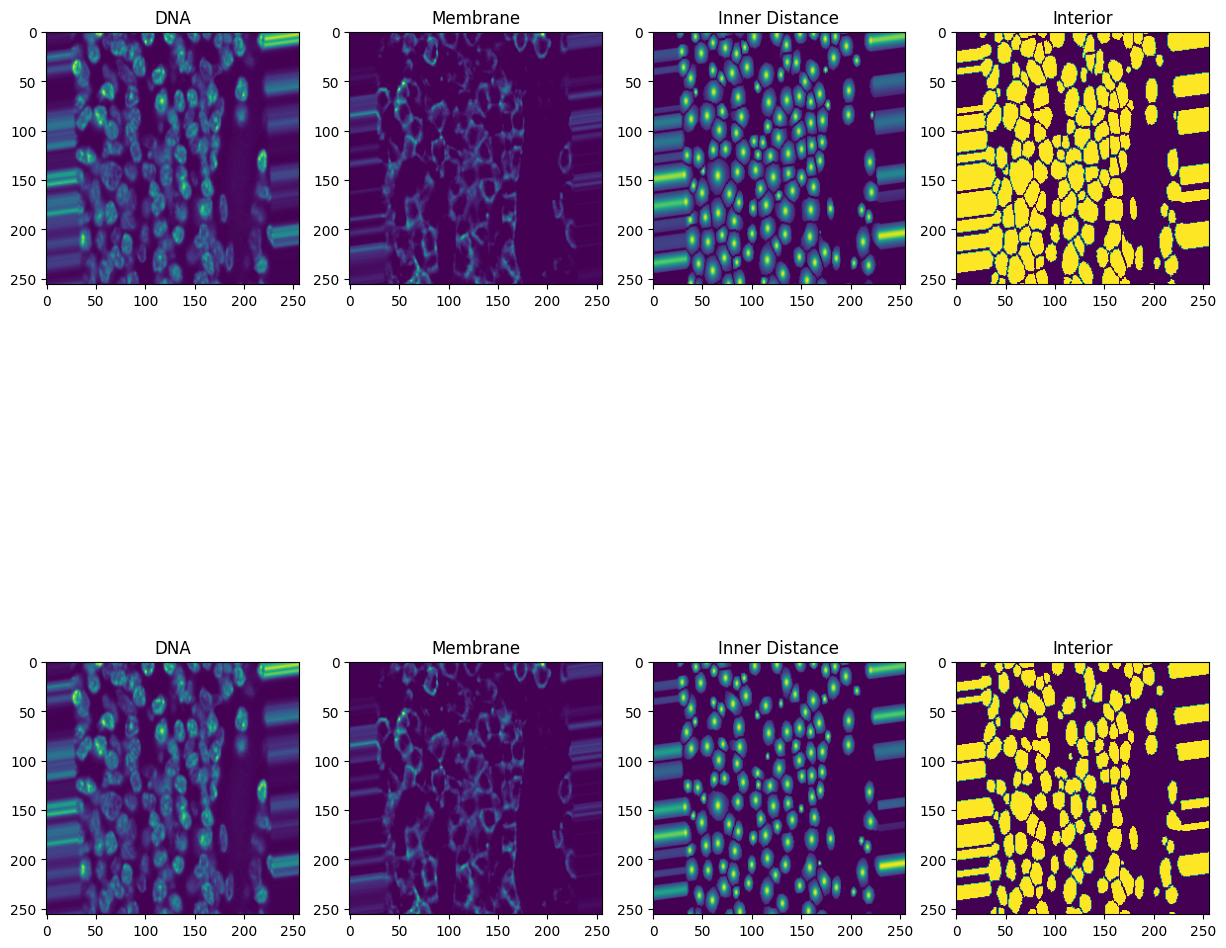

In [7]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
pixelwise = outputs[1]

inner_distance_nuc = outputs[2]
pixelwise_nuc = outputs[3]

fig, axes = plt.subplots(2, 4, figsize=(15, 15))

axes[0, 0].imshow(img[:, :, 0])
axes[0, 0].set_title('DNA')

axes[0, 1].imshow(img[:, :, 1])
axes[0, 1].set_title('Membrane')

axes[0, 2].imshow(inner_distance[0, ..., 0])
axes[0, 2].set_title('Inner Distance')

axes[0, 3].imshow(pixelwise[0, ..., 1])
axes[0, 3].set_title('Interior')

# nuclear
axes[1, 0].imshow(img[:, :, 0])
axes[1, 0].set_title('DNA')

axes[1, 1].imshow(img[:, :, 1])
axes[1, 1].set_title('Membrane')

axes[1, 2].imshow(inner_distance_nuc[0, ..., 0])
axes[1, 2].set_title('Inner Distance')

axes[1, 3].imshow(pixelwise_nuc[0, ..., 1])
axes[1, 3].set_title('Interior')

plt.show()